# Homepage Animation Tutorial

This notebook will cover the generation of the homepage animation. To run this notebook, please first generate the forcing fields by running all cells in `idealized_fields.ipynb` and generate the ray tracing output by running all cells in `canonical_ray_tracing.ipynb`.

In [58]:
# data handling
import xarray as xr
import numpy as np

# plotting
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import cmocean
from IPython.display import HTML
from matplotlib.animation import PillowWriter

## Setup

First, we open the forcing field datasets to use as the background of the animation.

In [2]:
zonal_jet = xr.open_dataset('./forcing/zonal_jet.nc')
eddy = xr.open_dataset('./forcing/mesoscale_eddy.nc')
island = xr.open_dataset('./forcing/gaussian_island.nc')
beach = xr.open_dataset('./forcing/gentle_slope.nc')

We then open the ray tracing bundles that were generated in `canonical_ray_tracing.ipynb`.

In [3]:
bundle4jet = xr.open_dataset('./output/bundle4zonal_jet.nc')
bundle4eddy = xr.open_dataset('./output/bundle4eddy.nc')
bundle4island = xr.open_dataset('./output/bundle4island.nc')
bundle4beach = xr.open_dataset('./output/bundle4beach.nc')

For the two examples of rays passing through canonical current fields, we calculate the current speed for the background.

In [4]:
zonal_speed = np.sqrt(zonal_jet.u**2 + zonal_jet.v**2)
eddy_speed = np.sqrt(eddy.u**2 + eddy.v**2)

We convert the x and y coordinates from meters to kilometers for clarity. The grid is the same for all examples, so we just take the coordinates from one of the examples.

In [5]:
x_km = zonal_jet.x / 1000
y_km = zonal_jet.y / 1000

For the zonal gaussian jet, we find extract the profile along the y-axis to plot on top of the current field. We scale it by an arbitrary value of 20 to make it visible on the plot.

In [6]:
x_target = 125_000
idx_target = int(np.argmin(np.abs(zonal_jet.x.values - x_target)))

# Extract y and speed profile at x = 125 km
y_vals = zonal_jet['y'].values / 1000  # in km
speed_profile = zonal_speed.isel(x=idx_target).values

# Normalize and offset profile to plot it over the field
speed_norm = speed_profile / np.nanmax(speed_profile)  # scale to [0, 1]
x_offset = 0.5 # km offset from the 125 km line
profile_x = 125 + speed_norm * 20 + x_offset  # amplify and offset for visibility

We also find the initial x and y values for the rays in the beach example to draw a line.

In [7]:
line_x = bundle4beach.isel(time_step=0)['x'] / 1000
line_y = bundle4beach.isel(time_step=0)['y'] / 1000

## Animation

We find the lowest `time_step` so that we don't run into out-of-bounds errors.

In [8]:
# Determine max time steps
time_steps = min(bundle4jet.time_step.size, 
                 bundle4eddy.time_step.size, 
                 bundle4island.time_step.size, 
                 bundle4beach.time_step.size)

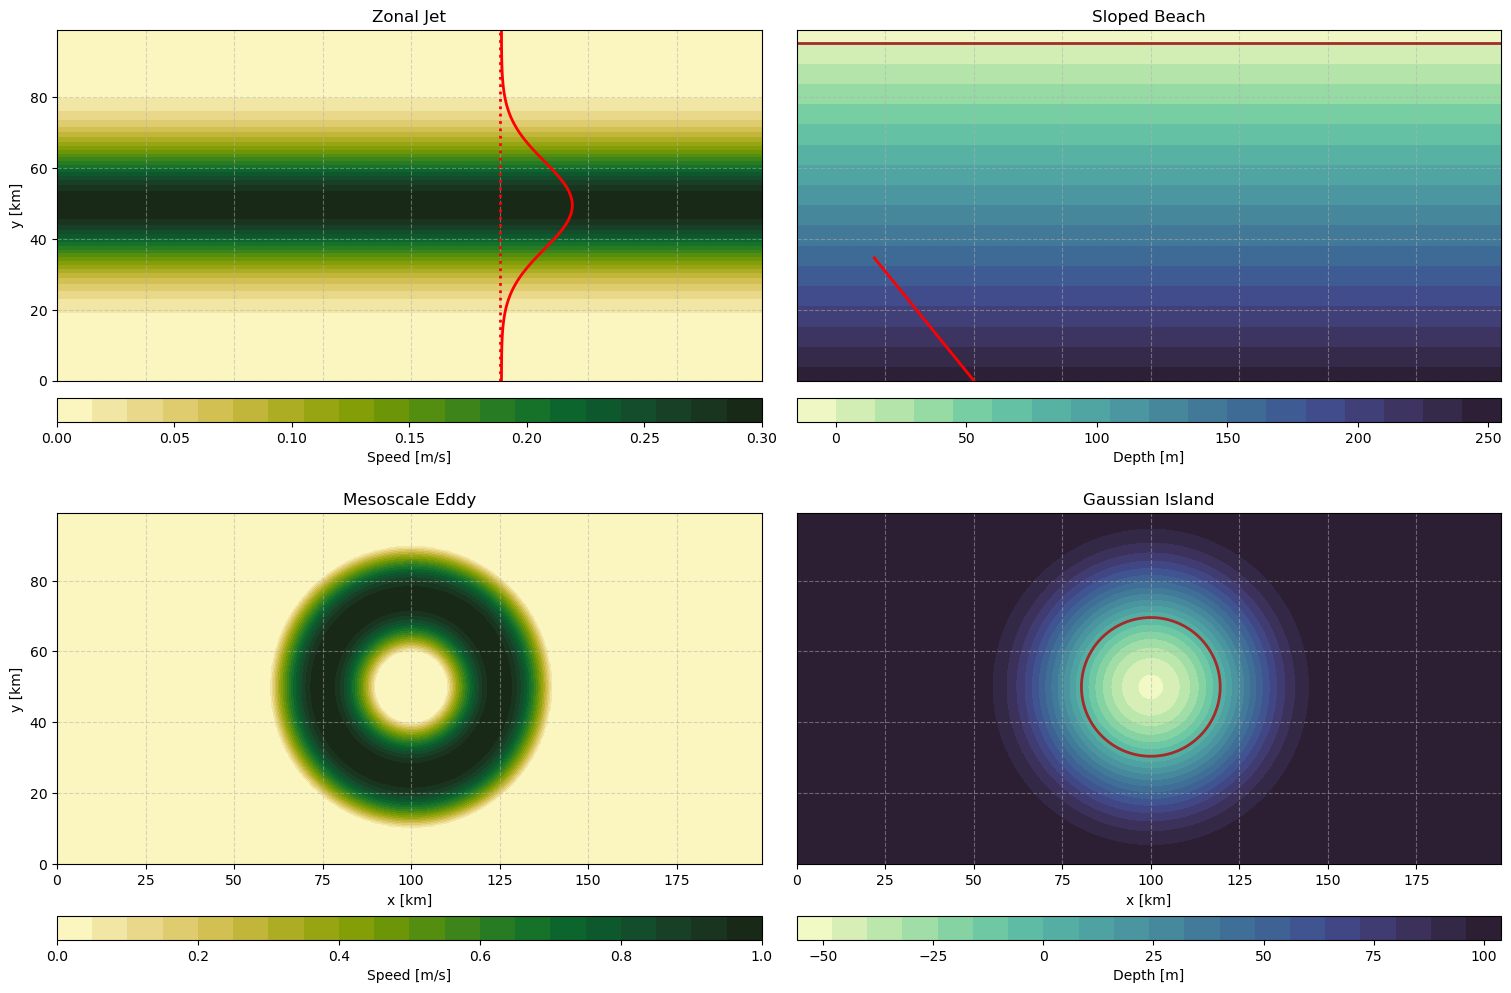

In [106]:
# ---STATIC BACKGROUND---
fig, axs = plt.subplots(2, 2, figsize=(15, 10), constrained_layout=True)

# Top left: zonal jet
cf_zj = axs[0, 0].contourf(x_km, y_km, zonal_speed, cmap=cmocean.cm.speed, levels=20)
axs[0, 0].axvline(125, color='red', linestyle=':', linewidth=2)
axs[0, 0].plot(profile_x, y_vals, color='red', linewidth=2)
axs[0, 0].set_title('Zonal Jet')
fig.colorbar(cf_zj, ax=axs[0, 0], 
             orientation='horizontal', location='bottom', 
             pad=0.02, shrink=1, aspect=30, 
             label='Speed [m/s]', 
             ticks=[0.0,0.05,0.1,0.15,0.2,0.25,0.3])

# Top right: beach
cf_beach = axs[0, 1].contourf(x_km, y_km, beach.depth, cmap=cmocean.cm.deep, levels=20)
axs[0, 1].contour(x_km, y_km, beach.depth, levels=[0], colors='brown', linewidths=2)
axs[0, 1].plot(line_x, line_y, color='red', linewidth=2)
axs[0, 1].set_title('Sloped Beach')
fig.colorbar(cf_beach, ax=axs[0, 1], 
             orientation='horizontal', location='bottom', 
             pad=0.02, shrink=1, aspect=30, 
             label='Depth [m]', 
             ticks=[0.0,50,100,150,200,250])

# Bottom left: mesoscale eddy
cf_eddy = axs[1, 0].contourf(x_km, y_km, eddy_speed, cmap=cmocean.cm.speed, levels=20)
axs[1, 0].set_title('Mesoscale Eddy')
fig.colorbar(cf_eddy, ax=axs[1, 0], 
             orientation='horizontal', location='bottom', 
             pad=0.02, shrink=1, aspect=30, 
             label='Speed [m/s]', 
             ticks=[0.0,0.2,0.40,0.6,0.8,1.0])

# Bottom right: gaussian island
cf_island = axs[1, 1].contourf(x_km, y_km, island.depth, cmap=cmocean.cm.deep, levels=20)
axs[1, 1].contour(x_km, y_km, island.depth, levels=[0], colors='brown', linewidths=2)
axs[1, 1].set_title('Gaussian Island')
fig.colorbar(cf_island, ax=axs[1, 1], 
             orientation='horizontal', location='bottom', 
             pad=0.02, shrink=1, aspect=30, 
             label='Depth [m]', 
             ticks=[-50,-25,0,25,50,75,100])

# Axis labels and settings
for ax in axs.flat:
    ax.set_aspect('equal')
    ax.grid(linestyle='--', alpha=0.5)

axs.flat[0].set_ylabel('y [km]')
axs.flat[2].set_ylabel('y [km]')
axs.flat[2].set_xlabel('x [km]')
axs.flat[3].set_xlabel('x [km]')

for ax in [axs.flat[0], axs.flat[1]]:
    ax.tick_params(axis='x', which='both', bottom=False, labelbottom=False)
for ax in [axs.flat[1], axs.flat[3]]:
    ax.tick_params(axis='y', which='both', left=False, labelleft=False)


# ---ANIMATION---
# Create empty line objects for rays in each panel
ray_lines_jet1 = [axs[0, 0].plot([], [], lw=0.8, color='black')[0] for i in range(bundle4jet.ray.size) if i % 2 == 0]
ray_lines_beach = [axs[0, 1].plot([], [], lw=0.8, color='white')[0] for i in range(bundle4beach.ray.size) if i % 2 == 0]
ray_lines_eddy = [axs[1, 0].plot([], [], lw=0.8, color='black')[0] for i in range(bundle4eddy.ray.size) if i % 2 == 0]
ray_lines_island = [axs[1, 1].plot([], [], lw=0.8, color='white')[0] for i in range(bundle4island.ray.size) if i % 2 == 0]

# Animation function
def animate(frame):
    for i, line in enumerate(ray_lines_jet1):
        ray = bundle4jet.isel(ray=2*i).sel(time_step=slice(0, frame))
        line.set_data(ray.x / 1e3, ray.y / 1e3)  # Convert to km

    for i, line in enumerate(ray_lines_beach):
        beach_frame = frame * 10  # or whatever slowdown factor you want
        ray = bundle4beach.isel(ray=2*i).sel(time_step=slice(0, beach_frame))
        line.set_data(ray.x / 1e3, ray.y / 1e3)

    for i, line in enumerate(ray_lines_eddy):
        ray = bundle4eddy.isel(ray=2*i).sel(time_step=slice(0, frame))
        line.set_data(ray.x / 1e3, ray.y / 1e3)

    for i, line in enumerate(ray_lines_island):
        ray = bundle4island.isel(ray=2*i).sel(time_step=slice(0, frame))
        line.set_data(ray.x / 1e3, ray.y / 1e3)

    return ray_lines_jet1 + ray_lines_beach + ray_lines_eddy + ray_lines_island

# Create the animation
anim = animation.FuncAnimation(
    fig, animate,
    frames=range(0, time_steps, 1),
    interval=40,
    blit=True
)

To show the animation, you can either a) use HTML to show it in the notebook (which will likely run into space issues) or b) save it as a gif. WARNING: This cell will take some time to output.

In [ ]:
# To display in notebook, uncomment:
# HTML(anim.to_jshtml())

# To save to file:
anim.save("demo_animation.gif", writer=PillowWriter(fps=25))